In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import glob
import os
import sys

import skimage
import skimage.io
import skimage.transform
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
MODE = "TESTING" # "TRAINING"

# Auxiliary functions

In [4]:
def extract_features(im):
    im = skimage.exposure.rescale_intensity(im)
    color_hist = []
    for c in range(3):
        if len(im.shape) == 3:
            color_hist.append( np.histogram(im[:,:,c], 255)[0] )
        else:
            color_hist.append( np.histogram(im[:,:], 255)[0] )
    feat = np.concatenate(color_hist)
    feat = feat / (im.shape[0] * im.shape[1] * 3 )
    return np.expand_dims(feat, axis=0)

In [5]:
def resize_pair(big, patch):
    ph, pw, pc = patch.shape
    bh, bw, bc = big.shape
    factor_h = bh/ph
    factor_w = bw/pw
    reverse_factor_h = bh/64
    reverse_factor_w = bw/64
    new_big = skimage.transform.resize(big, (64,64), anti_aliasing=False)
    new_patch = skimage.transform.resize(patch, (64/factor_h, 64/factor_w), anti_aliasing=False)
    return new_big, new_patch, reverse_factor_h, reverse_factor_w
    

def pixel_wise_match(big, patch):
    if len(big.shape) == len(patch.shape) == 3:
        ph, pw, pc = patch.shape
        bh, bw, bc = big.shape
    else:
        return [-3]
    
    # Different number of channels
    if bc != pc: 
        return [-1]
    
    # Same size images
    if bh == ph and bw == pw:
        d = np.sum(np.abs(big-patch))
        if d == 0:
            return 0,0
        
    # Patch size is an exact fraction of the big size
    if bh % ph == 0 and bw % pw == 0:
        d_min = 1e9
        x,y = 0,0
        nbig, npatch, rfh, rfw = resize_pair(big, patch)
        for i in range(nbig.shape[0] - npatch.shape[0] + 1):
            for j in range(nbig.shape[1] - npatch.shape[1] + 1):
                d = np.sum( np.abs(nbig[i:i+npatch.shape[0], j:j+npatch.shape[1]] - npatch) )
                # Exact positive match
                if d < 1e-6:
                    return int(rfh*i),int(rfw*j)
                if d < d_min:
                    d_min = d
                    y,x = i,j
        # It's a fraction but does not match
        return int(rfh*x),int(rfw*y),d_min
    else:
        # Not an exact fraction
        return [-2]

# Load original image sets

In [6]:
files = [x for x in glob.glob("/storage/data/DSB2018/image-sets/**", recursive=True)]
files = [x for x in files if x.endswith(".png") or x.endswith(".jpg")]
print(len(files))

1905


In [7]:
features = {}
for f in tqdm(files):
    im = skimage.io.imread(f)
    feat = extract_features(im)
    features[f] = feat

100%|██████████| 1905/1905 [01:18<00:00, 24.19it/s]


# Load competition image sets

In [8]:
training = [x for x in glob.glob("/storage/data/DSB2018/training-data/**/images/**", recursive=True) if x.endswith(".png")]
len(training)

670

In [9]:
testing = [x for x in glob.glob("/storage/data/DSB2018/phase-2-imgs/**", recursive=True) if x.endswith(".png")]
len(testing)

106

In [10]:
crops = {}
if MODE == "TRAINING":
    all_images = training
elif MODE == "TESTING":
    all_images = testing
    
for f in tqdm(all_images):
    im = skimage.io.imread(f)
    feat = extract_features(im)
    crops[f] = feat

100%|██████████| 106/106 [00:02<00:00, 43.91it/s]


# Compute distance matrix

In [11]:
dist = np.zeros((len(crops), len(features)))
i,j = 0,0
for c in tqdm(crops.keys()):
    for f in features.keys():
        dist[i,j] = np.sum( np.abs(crops[c] - features[f]) )
        j += 1
    i += 1
    j = 0

100%|██████████| 106/106 [00:01<00:00, 60.29it/s]


# Search crops in top matches

/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


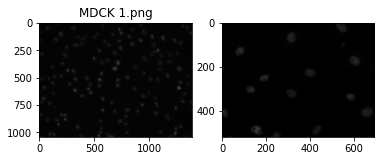

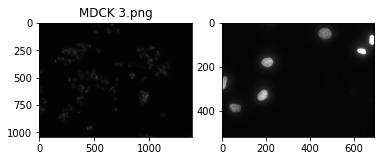

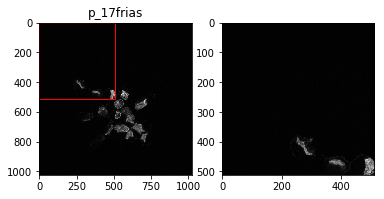

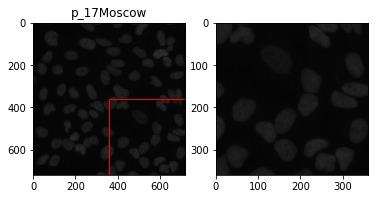

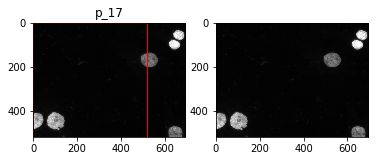

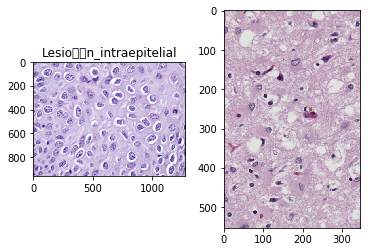

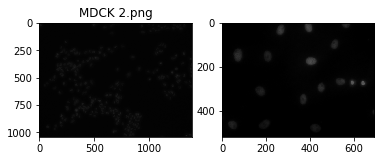

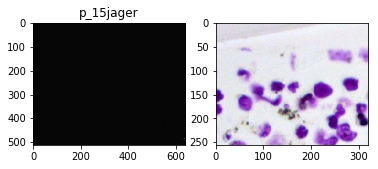

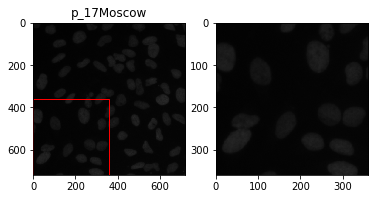

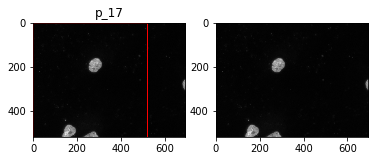

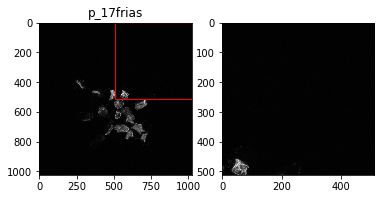

In [12]:
matches = np.argsort(dist, axis=1)
fkeys = list(features.keys())
ckeys = list(crops.keys())
exact_matches = 0
results_data = []

for i in range(len(crops)):
    match = None
    matchN = 0
    exact = False
    patch = skimage.io.imread(ckeys[i])
    for j in range(matches.shape[1]):
        big = skimage.io.imread( fkeys[matches[i,j]] )
        result = pixel_wise_match(big, patch)
        if len(result) >= 2:
            match = big
            matchN = j
        if len(result) == 2:
            exact = True
            exact_matches += 1
            break
            
    name = fkeys[matches[i,matchN]].split("/")[-1].split("_")
    if len(name) > 1:
        name = name[0] + "_" + name[1]
    else:
        name = name[0]
        
    if len(result) < 2: result.append(0)
    results_data.append({
        "crop": ckeys[i],
        "match":fkeys[matches[i,matchN]], 
        "project":name, 
        "exact":exact, 
        "coord_x":result[0],
        "coord_y":result[1]
    })
    
    # Image show
    if i % 10 != 0: continue
    if match is None:
        match = skimage.io.imread( fkeys[matches[i,0]] )    
    f, ax = plt.subplots(1,2)
    ax[0].imshow(match)
    ax[0].set_title(name)
    if exact:
        rect = matplotlib.patches.Rectangle((result[1],result[0]),patch.shape[0],patch.shape[1],linewidth=1,edgecolor='r',facecolor='none')
        ax[0].add_patch(rect)
    ax[1].imshow(patch)
    plt.show()

In [13]:
print("Exact matches:",exact_matches)
print("Missing:", len(crops) - exact_matches)

Exact matches: 58
Missing: 48


In [14]:
df = pd.DataFrame(data=results_data)
if MODE == "TRAINING":
    df.to_csv("matched_training_images.csv", index=False, encoding="utf-8")
elif MODE == "TESTING":
    with open("matched_testing_images.csv", "w", encoding="utf8", errors="replace") as f:
        df.to_csv(f, index=False)